### Import package

In [1]:
import pandas as pd
import numpy as np

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize  

# Scrape the web to get the data
from bs4 import BeautifulSoup
import requests

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# find the distances
from scipy.spatial.distance import cdist

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# translate Vietnamese character (with accents) 
#     to the closest possible representation in ascii text
from unidecode import unidecode

To start with our analysis, we used the BeautifulSoup package to transform the data in the table on the Wikipedia page into the below pandas dataframe. Data scraped has been saved into 'hcm_demograph.csv'

We also fetched the coordinate data for all the neighborhoods in HCM using the json file and put it into a dataframe.



In [3]:
hcm = pd.read_csv('hcm_demograph.csv', index_col=0)

In [6]:
hcm

,District,Subdistrict,Area (km2),Population 2015,Density (pop/Km2)
0,1,10 wards,7.73,193632,25049.418
1,2,11 wards,49.74,147168,2958.745
2,3,14 wards,4.92,196333,39905.081
3,4,15 wards,4.18,186727,44671.531
4,5,15 wards,4.27,178615,41830.211
5,6,14 wards,7.19,258945,36014.604
6,7,10 wards,35.69,310178,8690.894
7,8,16 wards,19.18,431969,22521.846
8,9,13 wards,114.00,290620,2549.298
9,10,15 wards,5.72,238558,41705.944


## House price

In [4]:
## I scrape data from https://mogi.vn/gia-nha-dat to get average house price for each district

In [5]:
source_housing_price = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(source_housing_price, 'lxml')
table_housing_price = soup.find("div", class_="mt-table")

In [6]:
table_rows = table_housing_price.find_all("div", class_="mt-row")
res_housing_price = []
for tr in table_rows:
    district = tr.find("div", class_="mt-street").a.text
    medium_price = tr.find("div", class_="mt-vol").span.text
    row = [district, medium_price]
    res_housing_price.append(row)

In [7]:
df_housing_price = pd.DataFrame(res_housing_price, 
                                columns=["District", "Average Housing Price (1M VND)"])
df_housing_price = df_housing_price.iloc[:19].reset_index().drop("index", axis=1)

# Remove the word "Quận"
df_housing_price["District"] = ( df_housing_price["District"]
                                        .str.replace("\n", "").str.replace("Quận", "")
                                        .str.strip() 
                                   )

# Remove Vietnamese accents
df_housing_price["District"] = df_housing_price["District"].apply(unidecode)

# Remove the word "triệu" (It's 10^6 in Vietnamese)
df_housing_price["Average Housing Price (1M VND)"] = ( df_housing_price["Average Housing Price (1M VND)"]
                                                .str.replace("triệu", "")
                                                 .str.replace(",", ".")
                                                 .str.strip()
                                            )
hcm_ahp = df_housing_price.copy()

In [10]:
hcm_ahp["Average Housing Price (1M VND)"]=hcm_ahp["Average Housing Price (1M VND)"].str.replace(" /m2",'')
hcm_ahp.rename(columns = {'Average Housing Price (1M VND)':'Average Housing Price (1M VND)/m2'}, inplace = True)
hcm_ahp

,District,Average Housing Price (1M VND)/m2
0,1,451
1,2,88.5
2,3,282
3,4,93.6
4,5,260
5,6,115
6,7,88.1
7,8,69.4
8,9,48.9
9,10,217


Merge hcm_demography and hcm_aph

In [11]:
df = pd.merge(hcm, hcm_ahp, how='left', left_on = 'District', right_on = 'District')
df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/Km2),Average Housing Price (1M VND)/m2
0,1,10 wards,7.73,193632,25049.418,451
1,2,11 wards,49.74,147168,2958.745,88.5
2,3,14 wards,4.92,196333,39905.081,282
3,4,15 wards,4.18,186727,44671.531,93.6
4,5,15 wards,4.27,178615,41830.211,260
5,6,14 wards,7.19,258945,36014.604,115
6,7,10 wards,35.69,310178,8690.894,88.1
7,8,16 wards,19.18,431969,22521.846,69.4
8,9,13 wards,114.00,290620,2549.298,48.9
9,10,15 wards,5.72,238558,41705.944,217


## Get coordinate for each district

In [12]:
def find_coor(name):
    address = name + " Ho Chi Minh City Vietnam"
    geolocator = Nominatim(user_agent="hcmc")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude]

In [13]:
# For District 1 to 12 (numbers)
coords = [find_coor("District " + dist) for dist in df["District"].iloc[:12].tolist()]

# For the other districts (letters)
coords = coords + [find_coor(dist + " District") for dist in df["District"].iloc[12:].tolist()]

df_coords = pd.DataFrame(coords, columns=["Latitude", "Longitude"])

df["Latitude"] = df_coords["Latitude"]
df["Longitude"] = df_coords["Longitude"]

df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/Km2),Average Housing Price (1M VND)/m2,Latitude,Longitude
0,1,10 wards,7.73,193632,25049.418,451,10.774540,106.699184
1,2,11 wards,49.74,147168,2958.745,88.5,10.791116,106.736729
2,3,14 wards,4.92,196333,39905.081,282,10.783529,106.687098
3,4,15 wards,4.18,186727,44671.531,93.6,10.759243,106.704890
4,5,15 wards,4.27,178615,41830.211,260,10.756129,106.670376
5,6,14 wards,7.19,258945,36014.604,115,10.746928,106.634495
6,7,10 wards,35.69,310178,8690.894,88.1,10.736573,106.722432
7,8,16 wards,19.18,431969,22521.846,69.4,10.740400,106.665843
8,9,13 wards,114.00,290620,2549.298,48.9,10.824543,106.818015
9,10,15 wards,5.72,238558,41705.944,217,10.773198,106.667833


In [14]:
### Opend data of Hanoi

In [21]:
hn = pd.read_csv('hn.csv')
hn

,District,Subdistrict,Area (km2),Population 2015,Density (pop/Km2),Average Housing Price (1M VND)/m2,Latitude,Longitude
0,Ba Dinh,14 wards,9.21,247100,26829.53312,167,21.0358,105.8217


In [22]:
## Concat Hanoi dataframe and HCMC dataframe, then clustering to see find out the similariites

In [23]:
df_new = pd.concat([df,hn],ignore_index=True)

In [24]:
df_new

,District,Subdistrict,Area (km2),Population 2015,Density (pop/Km2),Average Housing Price (1M VND)/m2,Latitude,Longitude
0,1,10 wards,7.73,193632,25049.41800,451,10.774540,106.699184
1,2,11 wards,49.74,147168,2958.74500,88.5,10.791116,106.736729
2,3,14 wards,4.92,196333,39905.08100,282,10.783529,106.687098
3,4,15 wards,4.18,186727,44671.53100,93.6,10.759243,106.704890
4,5,15 wards,4.27,178615,41830.21100,260,10.756129,106.670376
5,6,14 wards,7.19,258945,36014.60400,115,10.746928,106.634495
6,7,10 wards,35.69,310178,8690.89400,88.1,10.736573,106.722432
7,8,16 wards,19.18,431969,22521.84600,69.4,10.740400,106.665843
8,9,13 wards,114.00,290620,2549.29800,48.9,10.824543,106.818015
9,10,15 wards,5.72,238558,41705.94400,217,10.773198,106.667833


Find the geograpical coordinate of Ho Chi Minh City

In [26]:
[hcm_lat, hcm_long] = find_coor("")
print('The geograpical coordinate of Ho Chi Minh City are {}, {}.'.format(hcm_lat, hcm_long))

The geograpical coordinate of Ho Chi Minh City are 10.6497452, 106.76197937344351.


In [27]:
map_hcm = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)
for lat, lng, dis in zip(df['Latitude'], df_new['Longitude'], df_new['District']):
    label = '{}'.format(dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hcm)  

map_hcm

## 2. Explore Neighborhoods in HCMC and Ba Dinh District

### Define Foursquare Credentials and Version

In [39]:
CLIENT_ID = 'HYPQVPXISITEEP53JOWYMGRGOVWUC2FNBP0K5QFEEVSGFJBC'
CLIENT_SECRET = 'MO0GIXAYLVMISF3SZU4SSREGDFWJDOIY1ENBYLSH3FMJ1VZ2'
VERSION = '20200409'

### Let's explore the first neighborhood in our dataframe.

In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=150):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Get the neighborhood's latitude and longitude values.

In [41]:
hcm_venues = getNearbyVenues(names=df_new['District'],
                             latitudes=df_new['Latitude'],
                             longitudes=df_new['Longitude']
                            )

In [42]:
hcm_venues_group = hcm_venues.groupby('District').count().reset_index()
hcm_venues_group

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,100,100,100,100,100,100
1,10,100,100,100,100,100,100
2,11,39,39,39,39,39,39
3,12,9,9,9,9,9,9
4,2,58,58,58,58,58,58
5,3,100,100,100,100,100,100
6,4,69,69,69,69,69,69
7,5,100,100,100,100,100,100
8,6,21,21,21,21,21,21
9,7,60,60,60,60,60,60


In [43]:
print('In above table, there are {} uniques categories.'.format(len(hcm_venues['Venue Category'].unique())))

In above table, there are 148 uniques categories.


In [44]:
hcm_venues['Venue Category'].unique()[:50]

array(['Pizza Place', 'Brewery', 'Vietnamese Restaurant', 'Hotel',
       'Department Store', 'Spanish Restaurant', 'Jazz Club', 'Multiplex',
       'Supermarket', 'Steakhouse', 'Café', 'Massage Studio',
       'Clothing Store', 'Sushi Restaurant', 'Coffee Shop',
       'Dessert Shop', 'Italian Restaurant', 'Whisky Bar', 'Restaurant',
       'Asian Restaurant', 'Food Court', 'Tapas Restaurant',
       'Thai Restaurant', 'Burger Joint', 'German Restaurant', 'Bar',
       'Bookstore', 'Museum', 'Jewelry Store', 'Nightclub', 'Opera House',
       'Vegetarian / Vegan Restaurant', 'Hotel Bar', 'Cupcake Shop',
       'French Restaurant', 'Noodle House', 'Mexican Restaurant', 'Spa',
       'North Indian Restaurant', 'Middle Eastern Restaurant',
       'Cocktail Bar', 'Indian Restaurant', 'Sandwich Place', 'Park',
       'Hotpot Restaurant', 'Japanese Restaurant', 'Shoe Store',
       'BBQ Joint', 'Beer Bar', 'Bakery'], dtype=object)

In [45]:
most_venues = hcm_venues.groupby('Venue Category').count().sort_values(by="Venue", ascending=False)
most_venues.head(15)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Vietnamese Restaurant,139,139,139,139,139,139
Café,137,137,137,137,137,137
Coffee Shop,86,86,86,86,86,86
Hotel,42,42,42,42,42,42
Seafood Restaurant,35,35,35,35,35,35
Chinese Restaurant,28,28,28,28,28,28
Asian Restaurant,25,25,25,25,25,25
Vegetarian / Vegan Restaurant,23,23,23,23,23,23
Japanese Restaurant,21,21,21,21,21,21


Text(0, 0.5, 'Number of categories')

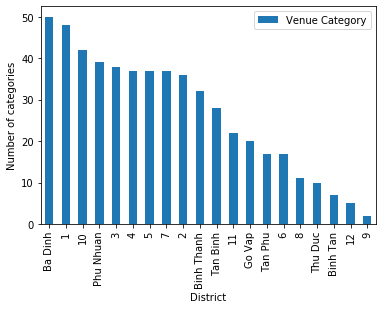

In [46]:
hcm_venues_group_cat = (
    hcm_venues.groupby(['District','Venue Category'])
        .count().reset_index()[['District', 'Venue Category']]
            .groupby('District').count().reset_index()
)
# hcm_venues_group_cat
ax = hcm_venues_group_cat.sort_values(by="Venue Category", ascending=False).plot(x="District", y="Venue Category", kind="bar")
ax.set_ylabel("Number of categories")

### Create a new dataframe of common venues

In [47]:
# one hot encoding
hcm_onehot = pd.get_dummies(hcm_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
hcm_onehot['District'] = hcm_venues['District'] 

# move district column to the first column
fixed_columns = [hcm_onehot.columns[-1]] + list(hcm_onehot.columns[:-1])
hcm_onehot = hcm_onehot[fixed_columns]

# group the rows by district and by taking the mean of the frequency of occurrence of each category
hcm_grouped = hcm_onehot.groupby('District').mean().reset_index()
hcm_grouped.head()

,District,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Wedding Hall,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio
0,1,0.000000,0.0,0.00,0.010000,0.0,0.000000,0.010000,0.000000,0.020000,...,0.000000,0.020000,0.130000,0.0,0.000000,0.0,0.01,0.0,0.0,0.0
1,10,0.000000,0.0,0.01,0.020000,0.0,0.000000,0.010000,0.000000,0.000000,...,0.000000,0.020000,0.190000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0
2,11,0.025641,0.0,0.00,0.025641,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.025641,0.128205,0.0,0.025641,0.0,0.00,0.0,0.0,0.0
3,12,0.000000,0.0,0.00,0.000000,0.0,0.111111,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.333333,0.0,0.000000,0.0,0.00,0.0,0.0,0.0
4,2,0.000000,0.0,0.00,0.051724,0.0,0.000000,0.068966,0.034483,0.034483,...,0.017241,0.000000,0.103448,0.0,0.000000,0.0,0.00,0.0,0.0,0.0


In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hcm_10 = pd.DataFrame(columns=columns)
hcm_10['District'] = hcm_grouped['District']

for ind in np.arange(hcm_grouped.shape[0]):
    hcm_10.iloc[ind, 1:] = return_most_common_venues(hcm_grouped.iloc[ind, :], num_top_venues)

hcm_10

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Hotel,Vietnamese Restaurant,Café,Coffee Shop,Massage Studio,Hotel Bar,Italian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Pizza Place
1,10,Vietnamese Restaurant,Café,Coffee Shop,Dessert Shop,Seafood Restaurant,Market,Spa,Bookstore,Snack Place,Gym / Fitness Center
2,11,Café,Vietnamese Restaurant,Chinese Restaurant,Seafood Restaurant,Cantonese Restaurant,Gym / Fitness Center,Noodle House,Coffee Shop,Dumpling Restaurant,Shopping Mall
3,12,Café,Vietnamese Restaurant,Diner,Department Store,Auto Garage,Yoga Studio,Food & Drink Shop,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
4,2,Vietnamese Restaurant,BBQ Joint,Restaurant,Café,Asian Restaurant,Coffee Shop,Bakery,Burger Joint,Tea Room,Bar
5,3,Vietnamese Restaurant,Café,Coffee Shop,Vegetarian / Vegan Restaurant,Hotel,Asian Restaurant,Pizza Place,Noodle House,Spa,Seafood Restaurant
6,4,Vietnamese Restaurant,Seafood Restaurant,Café,Coffee Shop,Restaurant,Japanese Restaurant,Mexican Restaurant,Food,Hostel,Snack Place
7,5,Chinese Restaurant,Vietnamese Restaurant,Café,Coffee Shop,Dessert Shop,Dim Sum Restaurant,Noodle House,Asian Restaurant,Seafood Restaurant,BBQ Joint
8,6,Coffee Shop,Café,Flea Market,Food & Drink Shop,Food Truck,Boutique,Movie Theater,Bookstore,Soup Place,Food Court
9,7,Vietnamese Restaurant,Café,Coffee Shop,Sushi Restaurant,Flea Market,Gym / Fitness Center,Hotel,Japanese Restaurant,Spa,Golf Course


In [49]:
hcm_grouped_res = hcm_grouped[["District", "Vietnamese Restaurant"]]
hcm_grouped_res

,District,Vietnamese Restaurant
0,1,0.130000
1,10,0.190000
2,11,0.128205
3,12,0.333333
4,2,0.103448
5,3,0.150000
6,4,0.159420
7,5,0.130000
8,6,0.047619
9,7,0.083333


## Cluster Neighborhoods

### Find optimal number of clusters

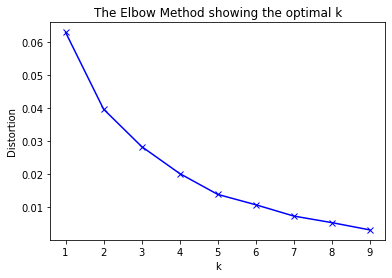

In [50]:
# try with 10 different values of k to find the best one
Ks = 10
distortions = []

hcm_res_clustering = hcm_grouped_res.drop('District', 1)

for k in range(1, Ks):

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(hcm_res_clustering)

    # find the distortion w.r.t each k
    distortions.append(
        sum(np.min(cdist(hcm_res_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1))
        / hcm_res_clustering.shape[0]
    )

plt.plot(range(1, Ks), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [51]:
# The optimal number of lusters is 4
nclusters = 4
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(hcm_res_clustering)

In [53]:
df_res = hcm_grouped_res.copy()
df_res["Cluster Labels"] = kmeans.labels_

# add two columns Latitude and Logitude into cafe_merged
df_res = df_res.join(df_new.set_index("District"), on="District")

# sort the table by cluster labels
df_res.sort_values(["Cluster Labels"], inplace=True)

# Drop some unnecessary columns
df_res = df_res.drop(["Subdistrict", "Area (km2)"], axis=1)

# change to numeric date type
df_res['Average Housing Price (1M VND)/m2'] = df_res['Average Housing Price (1M VND)/m2'].astype(float)


df_res_hcm = df_res.drop((df.index[12]))
df_res

,District,Vietnamese Restaurant,Cluster Labels,Population 2015,Density (pop/Km2),Average Housing Price (1M VND)/m2,Latitude,Longitude
19,Thu Duc,0.000000,0,528413,10619.23200,66.1,10.852588,106.755838
15,Go Vap,0.032258,0,634146,32124.92400,99.4,10.840150,106.671083
8,6,0.047619,0,258945,36014.60400,115.0,10.746928,106.634495
18,Tan Phu,0.000000,0,464493,28922.35400,106.0,10.791640,106.627302
11,9,0.000000,0,290620,2549.29800,48.9,10.824543,106.818015
1,10,0.190000,1,238558,41705.94400,217.0,10.773198,106.667833
17,Tan Binh,0.229730,1,459029,20510.67900,153.0,10.797979,106.653805
16,Phu Nhuan,0.150000,1,182477,37392.82800,190.0,10.800118,106.677042
5,3,0.150000,1,196333,39905.08100,282.0,10.783529,106.687098
6,4,0.159420,1,186727,44671.53100,93.6,10.759243,106.704890


In [54]:
# create map
map_clusters = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i+x+(i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_res_hcm['Latitude'], 
        df_res_hcm['Longitude'], 
        df_res_hcm['District'], 
        df_res_hcm['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [55]:
count, division = np.histogram(df_res['Average Housing Price (1M VND)/m2'], bins = 4)

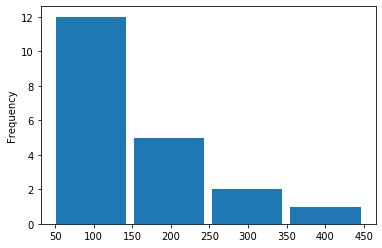

In [57]:
df_res['Average Housing Price (1M VND)/m2'].plot.hist(bins=division, rwidth=0.9)

In [58]:
def classify_ahp(price):
    if price <= 100:
        return "Low"
    elif price <= 200:
        return "Medium"
    elif price <= 300:
        return "High"
    else:
        return "Very High"

In [60]:
df_res["AHP Level"] = df_res["Average Housing Price (1M VND)/m2"].apply(classify_ahp)
df_res.

,District,Vietnamese Restaurant,Cluster Labels,Population 2015,Density (pop/Km2),Average Housing Price (1M VND)/m2,Latitude,Longitude,AHP Level
19,Thu Duc,0.000000,0,528413,10619.23200,66.1,10.852588,106.755838,Low
15,Go Vap,0.032258,0,634146,32124.92400,99.4,10.840150,106.671083,Low
8,6,0.047619,0,258945,36014.60400,115.0,10.746928,106.634495,Medium
18,Tan Phu,0.000000,0,464493,28922.35400,106.0,10.791640,106.627302,Medium
11,9,0.000000,0,290620,2549.29800,48.9,10.824543,106.818015,Low
1,10,0.190000,1,238558,41705.94400,217.0,10.773198,106.667833,High
17,Tan Binh,0.229730,1,459029,20510.67900,153.0,10.797979,106.653805,Medium
16,Phu Nhuan,0.150000,1,182477,37392.82800,190.0,10.800118,106.677042,Medium
5,3,0.150000,1,196333,39905.08100,282.0,10.783529,106.687098,High
6,4,0.159420,1,186727,44671.53100,93.6,10.759243,106.704890,Low


In [62]:
hcm_geo = r'hcm_urban.geojson' # geojson file

map_ahp = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)

map_ahp.choropleth(
 geo_data=hcm_geo,
 name='choropleth',
 data=df_res,
 columns=['District', 'Average Housing Price (1M VND)/m2'],
 key_on='feature.properties.name',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Average Housing Price (1M VND)/m2'
)
# folium.LayerControl().add_to(map_ahp)

# add clusters to the map
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_res['Latitude'], 
        df_res['Longitude'], 
        df_res['District'], 
        df_res['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_ahp)

map_ahp

From all above results, we conclude that, the best place for us to set up a new restaurant is in district Binh Tan because there are a lot of people living there (high density), there are alot of shopping malls, Multiplexies, there are not many already-working Vietnamese Restaurant and the average housing price is low.